## Context for the problem

Bob has started his own mobile company. He wants to give tough fight to big companies like Apple,Samsung etc.
He does not know how to estimate price of mobiles his company creates. In this competitive mobile phone market you cannot simply assume things. To solve this problem he collects sales data of mobile phones of various companies.
Bob wants to find out some relation between features of a mobile phone(eg:- RAM,Internal Memory etc) and its selling price. But he is not so good at Machine Learning. So he needs your help to solve this problem.
In this problem you do not have to predict actual price but a price range indicating how high the price is

## Install Packages

In [111]:
!pip install requests
!pip install tabulate
!pip install "colorama>=0.3.8"
!pip install future

!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o



Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html


## Import Libraries

In [112]:
# Import libraries
# Use pip install or conda install if missing a library
import warnings
warnings.filterwarnings('ignore')
import h2o
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Start AutoML Server

In [113]:
# Set a minimum memory size and a run time in seconds
min_mem_size=6 
run_time=222

In [114]:
# Use 50% of availible resources
pct_memory=0.75
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

4


In [115]:
# 65535 Highest port no
# Start the H2O server on a random port
port_no=random.randint(5555,55555)

#  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
try:
  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
except:
  logging.critical('h2o.init')
  h2o.download_all_logs(dirname=logs_path, filename=logfile)      
  h2o.cluster().shutdown()
  sys.exit(2)

Checking whether there is an H2O instance running at http://localhost:38524 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.13" 2021-10-19; OpenJDK Runtime Environment (build 11.0.13+8-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.13+8-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpvktagtcx
  JVM stdout: /tmp/tmpvktagtcx/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpvktagtcx/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:38524
Connecting to H2O server at http://127.0.0.1:38524 ... successful.


H2O_cluster_uptime:,05 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.0.2
H2O_cluster_version_age:,19 days
H2O_cluster_name:,H2O_from_python_unknownUser_nrfppf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


## Importing the dataset from Github  repo

In [116]:
# Download the train data csv file and load in the training dataset 
train_url = "https://raw.githubusercontent.com/pratikg17neu/DS_6105__Assignment1/main/dataset/train.csv"
df = h2o.import_file(path = train_url)

pct_rows=0.80
df_train, df_test = df.split_frame([pct_rows])

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


### Displaying the head of train data

In [117]:
df_train.head()

battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,1
1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,2
563,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0,2
1821,1,1.2,0,13,1,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0,1
1859,0,0.5,1,3,0,22,0.7,164,1,7,1004,1654,1067,17,1,10,1,0,0,1
1954,0,0.5,1,0,0,24,0.8,187,4,0,512,1149,700,16,3,5,1,1,1,0
1445,1,0.5,0,0,0,53,0.7,174,7,14,386,836,1099,17,1,20,1,0,0,0
769,1,2.9,1,0,0,9,0.1,182,5,1,248,874,3946,5,2,7,0,0,0,3
1520,1,2.2,0,5,1,33,0.5,177,8,18,151,1005,3826,14,9,13,1,1,1,3
1815,0,2.8,0,2,0,33,0.6,159,4,17,607,748,1482,18,0,2,1,0,0,1


### Displaying the head of test data

In [118]:
df_test.head()

battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
615,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0,2
1821,0,1.7,0,4,1,10,0.8,139,8,10,381,1018,3220,13,8,18,1,0,1,3
509,1,0.6,1,2,1,9,0.1,93,5,15,1137,1224,513,19,10,12,1,0,0,0
803,1,2.1,0,7,0,17,1,198,4,11,344,1440,2680,7,1,4,1,0,1,2
772,0,1.1,1,12,0,39,0.8,81,7,14,1314,1854,2819,17,15,3,1,1,0,3
1949,0,2.6,1,4,0,47,0.3,199,4,7,407,822,1433,11,5,20,0,0,1,1
790,0,2,1,16,1,11,0.3,87,6,17,347,730,3169,6,1,2,1,0,1,2
1195,1,2.8,0,1,1,20,0.8,110,2,14,1580,1652,504,9,3,12,1,1,0,0
1514,0,2.9,0,0,0,27,0.2,118,3,1,186,1810,1152,8,3,20,0,1,1,1
1936,0,2.1,1,10,1,46,0.6,104,3,20,667,1036,2552,14,7,13,1,0,0,2


### Shape of both the dataset

In [119]:
df_train.shape


(1598, 21)

In [120]:
df_test.shape

(402, 21)

## Train the model using H2O's AutoML 

In [121]:
X = df_train.columns
print(X)

['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g', 'touch_screen', 'wifi', 'price_range']


In [122]:
y = 'price_range'
X.remove(y)


In [123]:
# Set up AutoML
aml = H2OAutoML(max_runtime_secs=run_time, seed=1)

In [124]:
aml.train(x=X,y=y,training_frame=df_train)  

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_4_AutoML_1_20220214_44128

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.019168885472078057
RMSE: 0.1384517442002016
MAE: 0.10710947668760548
RMSLE: 0.06900629829011741
R^2: 0.984726059066297
Mean Residual Deviance: 0.019168885472078057
Null degrees of freedom: 1597
Residual degrees of freedom: 1592
Null deviance: 2005.4993742177749
Residual deviance: 30.631878984380734
AIC: -1770.310494610621

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.06834569881922957
RMSE: 0.2614301031236257
MAE: 0.1948405034841453
RMSLE: 0.12847877990763323
R^2: 0.9455415303952773
Mean Residual Deviance: 0.06834569881922957
Null degrees of freedom: 1597
Residual degrees of freedom: 1592
Null deviance: 200

In [125]:
print(aml.leaderboard)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_BestOfFamily_4_AutoML_1_20220214_44128,0.0683457,0.26143,0.0683457,0.194841,0.128479
StackedEnsemble_AllModels_3_AutoML_1_20220214_44128,0.0687341,0.262172,0.0687341,0.190341,0.128083
StackedEnsemble_AllModels_2_AutoML_1_20220214_44128,0.0691206,0.262908,0.0691206,0.196333,0.12947
StackedEnsemble_BestOfFamily_3_AutoML_1_20220214_44128,0.0697195,0.264044,0.0697195,0.198361,0.130135
StackedEnsemble_AllModels_1_AutoML_1_20220214_44128,0.0718267,0.268005,0.0718267,0.199915,0.133122
StackedEnsemble_BestOfFamily_2_AutoML_1_20220214_44128,0.0725743,0.269396,0.0725743,0.200696,0.134241
GBM_grid_1_AutoML_1_20220214_44128_model_5,0.0735051,0.271118,0.0735051,0.185508,0.13244
GBM_4_AutoML_1_20220214_44128,0.0760225,0.275722,0.0760225,0.200385,0.136826
GBM_grid_1_AutoML_1_20220214_44128_model_2,0.0766095,0.276784,0.0766095,0.20817,0.137382
GBM_2_AutoML_1_20220214_44128,0.0787279,0.280585,0.0787279,0.21118,0.141429


In [126]:
model_index=0
glm_index=0
glm_model=''
aml_leaderboard_df=aml.leaderboard.as_data_frame()
models_dict={}
for m in aml_leaderboard_df['model_id']:
  models_dict[m]=model_index
  if 'StackedEnsemble' not in m:
    break 
  model_index=model_index+1  

for m in aml_leaderboard_df['model_id']:
  if 'GLM' in m:
    models_dict[m]=glm_index
    break  
  glm_index=glm_index+1     
models_dict


{'GBM_grid_1_AutoML_1_20220214_44128_model_5': 6,
 'GLM_1_AutoML_1_20220214_44128': 50,
 'StackedEnsemble_AllModels_1_AutoML_1_20220214_44128': 4,
 'StackedEnsemble_AllModels_2_AutoML_1_20220214_44128': 2,
 'StackedEnsemble_AllModels_3_AutoML_1_20220214_44128': 1,
 'StackedEnsemble_BestOfFamily_2_AutoML_1_20220214_44128': 5,
 'StackedEnsemble_BestOfFamily_3_AutoML_1_20220214_44128': 3,
 'StackedEnsemble_BestOfFamily_4_AutoML_1_20220214_44128': 0}

In [127]:
print(model_index)
best_model = h2o.get_model(aml.leaderboard[model_index,'model_id'])

6


In [128]:
best_model.algo

'gbm'

In [129]:
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore", category = matplotlib.cbook.mplDeprecation)

**Feature Importance**


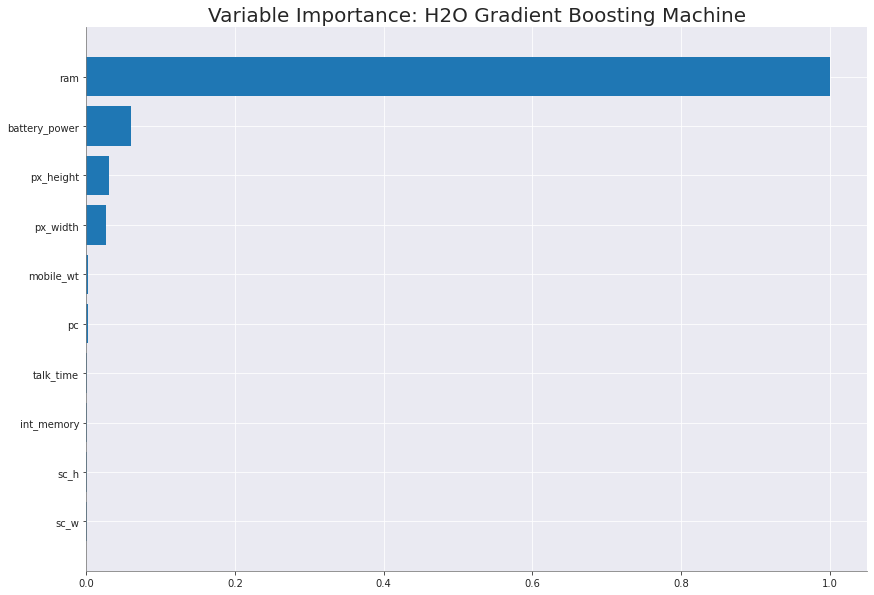

<Figure size 432x288 with 0 Axes>

In [130]:
if best_model.algo in ['gbm','drf','xrt','xgboost']:
  best_model.varimp_plot()

50
glm


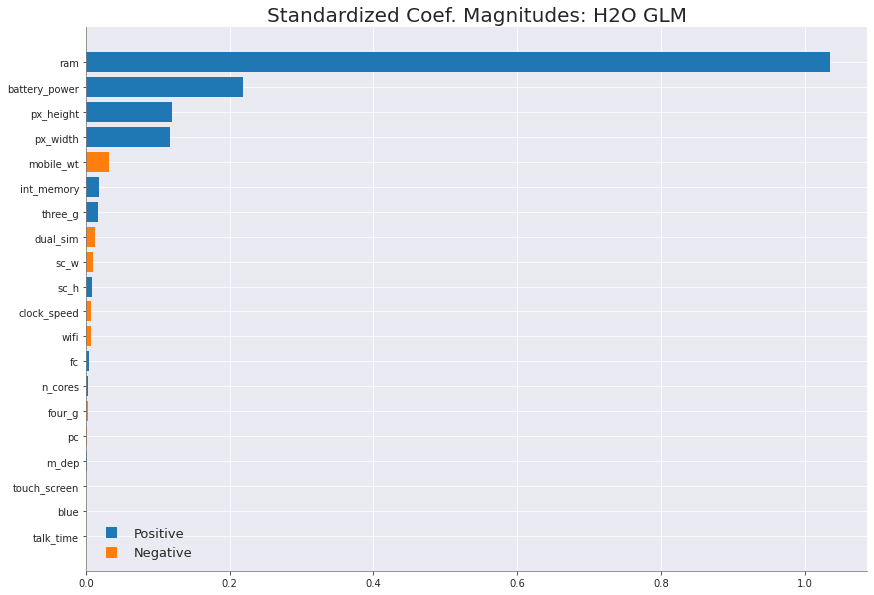

In [131]:
if glm_index is not 0:
  print(glm_index)
  glm_model=h2o.get_model(aml.leaderboard[glm_index,'model_id'])
  print(glm_model.algo) 
  glm_model.std_coef_plot()

In [132]:
print(best_model.rmse(train = True))

0.09695136914940712


In [133]:
def model_performance_stats(perf):
    d={}
    try:    
      d['mse']=perf.mse()
    except:
      pass      
    try:    
      d['rmse']=perf.rmse() 
    except:
      pass      
    try:    
      d['null_degrees_of_freedom']=perf.null_degrees_of_freedom()
    except:
      pass      
    try:    
      d['residual_degrees_of_freedom']=perf.residual_degrees_of_freedom()
    except:
      pass      
    try:    
      d['residual_deviance']=perf.residual_deviance() 
    except:
      pass      
    try:    
      d['null_deviance']=perf.null_deviance() 
    except:
      pass      
    try:    
      d['aic']=perf.aic() 
    except:
      pass      
    try:
      d['logloss']=perf.logloss() 
    except:
      pass    
    try:
      d['auc']=perf.auc()
    except:
      pass  
    try:
      d['gini']=perf.gini()
    except:
      pass    
    return d

In [134]:
mod_perf=best_model.model_performance(df_test)
stats_test={}
stats_test=model_performance_stats(mod_perf)
stats_test

{'mse': 0.0718543204019055,
 'null_degrees_of_freedom': None,
 'null_deviance': None,
 'residual_degrees_of_freedom': None,
 'residual_deviance': None,
 'rmse': 0.26805656194524596}

In [135]:
predictions = best_model.predict(df_test)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [136]:
y_pred=h2o.as_list(predictions)
y_pred[0:5]

,predict
0,2.223311
1,2.896217
2,-0.045754
3,1.734814
4,2.531849


In [137]:
print(X)

['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g', 'touch_screen', 'wifi']


PartialDependencePlot progress: |████████████████████████████████████████████████| (done) 100%

PartialDependence: Partial Dependence Plot of model GBM_grid_1_AutoML_1_20220214_44128_model_5 on column 'ram'.


,ram,mean_response,stddev_response,std_error_mean_response
0,256.000000,0.046572,0.173368,0.003877
1,452.947368,0.055903,0.177584,0.003971
2,649.894737,0.099556,0.224508,0.005020
3,846.842105,0.249589,0.306516,0.006854
4,1043.789474,0.274334,0.336070,0.007515
5,1240.736842,0.576174,0.412942,0.009234
6,1437.684211,0.717426,0.418500,0.009358
7,1634.631579,1.061400,0.351441,0.007858
8,1831.578947,1.145446,0.349455,0.007814
9,2028.526316,1.419240,0.434205,0.009709


[]

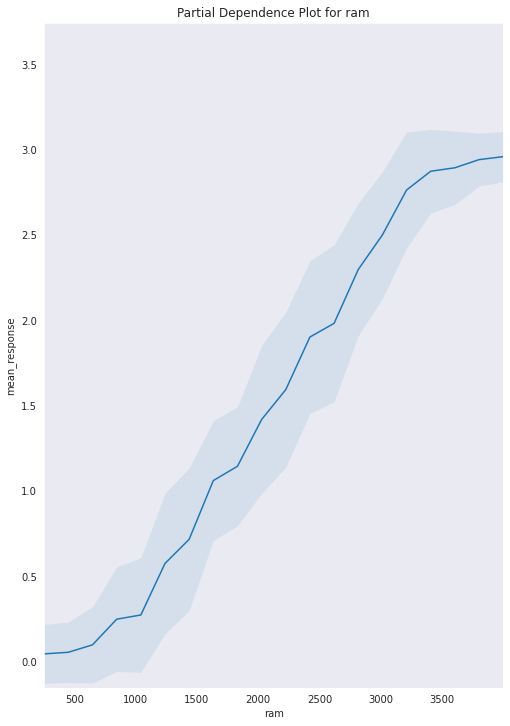

In [138]:
best_model.partial_plot(df, cols=['ram'])

PartialDependencePlot progress: |████████████████████████████████████████████████| (done) 100%

PartialDependence: Partial Dependence Plot of model GBM_grid_1_AutoML_1_20220214_44128_model_5 on column 'battery_power'.


,battery_power,mean_response,stddev_response,std_error_mean_response
0,501.000000,1.205153,1.002586,0.022419
1,579.789474,1.182913,1.001413,0.022392
2,658.578947,1.247588,1.039674,0.023248
3,737.368421,1.274932,1.072036,0.023971
4,816.157895,1.309377,1.085025,0.024262
5,894.947368,1.319363,1.086321,0.024291
6,973.736842,1.355667,1.092954,0.024439
7,1052.526316,1.396698,1.102679,0.024657
8,1131.315789,1.489723,1.083636,0.024231
9,1210.105263,1.489215,1.081259,0.024178



PartialDependence: Partial Dependence Plot of model GBM_grid_1_AutoML_1_20220214_44128_model_5 on column 'px_height'.


,px_height,mean_response,stddev_response,std_error_mean_response
0,0.000000,1.365775,1.072530,0.023983
1,103.157895,1.384011,1.079756,0.024144
2,206.315789,1.396256,1.084275,0.024245
3,309.473684,1.409471,1.100864,0.024616
4,412.631579,1.440139,1.095544,0.024497
5,515.789474,1.461331,1.096284,0.024514
6,618.947368,1.487988,1.092848,0.024437
7,722.105263,1.525011,1.086712,0.024300
8,825.263158,1.547399,1.096374,0.024516
9,928.421053,1.581345,1.091962,0.024417



PartialDependence: Partial Dependence Plot of model GBM_grid_1_AutoML_1_20220214_44128_model_5 on column 'px_width'.


,px_width,mean_response,stddev_response,std_error_mean_response
0,500.000000,1.347442,1.052189,0.023528
1,578.842105,1.347442,1.052189,0.023528
2,657.684211,1.368225,1.055048,0.023592
3,736.526316,1.392608,1.056529,0.023625
4,815.368421,1.402256,1.060571,0.023715
5,894.210526,1.424500,1.059686,0.023695
6,973.052632,1.423976,1.061110,0.023727
7,1051.894737,1.452061,1.072772,0.023988
8,1130.736842,1.483870,1.083100,0.024219
9,1209.578947,1.497849,1.086664,0.024299



PartialDependence: Partial Dependence Plot of model GBM_grid_1_AutoML_1_20220214_44128_model_5 on column 'clock_speed'.


,clock_speed,mean_response,stddev_response,std_error_mean_response
0,0.500000,1.504971,1.094242,0.024468
1,0.631579,1.505760,1.093113,0.024443
2,0.763158,1.510593,1.094113,0.024465
3,0.894737,1.508746,1.093476,0.024451
4,1.026316,1.506785,1.090446,0.024383
5,1.157895,1.505271,1.090422,0.024383
6,1.289474,1.503900,1.088014,0.024329
7,1.421053,1.505395,1.089262,0.024357
8,1.552632,1.507239,1.091051,0.024397
9,1.684211,1.507472,1.091023,0.024396



PartialDependence: Partial Dependence Plot of model GBM_grid_1_AutoML_1_20220214_44128_model_5 on column 'dual_sim'.


,dual_sim,mean_response,stddev_response,std_error_mean_response
0,0.0,1.508348,1.093559,0.024453
1,1.0,1.501814,1.097322,0.024537



PartialDependence: Partial Dependence Plot of model GBM_grid_1_AutoML_1_20220214_44128_model_5 on column 'four_g'.


,four_g,mean_response,stddev_response,std_error_mean_response
0,0.0,1.500781,1.092718,0.024434
1,1.0,1.508847,1.097198,0.024534



PartialDependence: Partial Dependence Plot of model GBM_grid_1_AutoML_1_20220214_44128_model_5 on column 'int_memory'.


,int_memory,mean_response,stddev_response,std_error_mean_response
0,2.000000,1.498565,1.082716,0.024210
1,5.263158,1.498565,1.082716,0.024210
2,8.526316,1.492618,1.088158,0.024332
3,11.789474,1.490690,1.090290,0.024380
4,15.052632,1.490414,1.091664,0.024410
5,18.315789,1.493681,1.091066,0.024397
6,21.578947,1.500532,1.094806,0.024481
7,24.842105,1.500203,1.096941,0.024528
8,28.105263,1.503603,1.098414,0.024561
9,31.368421,1.504578,1.097819,0.024548



PartialDependence: Partial Dependence Plot of model GBM_grid_1_AutoML_1_20220214_44128_model_5 on column 'm_dep'.


,m_dep,mean_response,stddev_response,std_error_mean_response
0,0.100000,1.506153,1.098126,0.024555
1,0.147368,1.506153,1.098126,0.024555
2,0.194737,1.504217,1.096909,0.024528
3,0.242105,1.504182,1.096956,0.024529
4,0.289474,1.502461,1.096678,0.024522
5,0.336842,1.502497,1.096726,0.024524
6,0.384211,1.501237,1.094833,0.024481
7,0.431579,1.501237,1.094833,0.024481
8,0.478947,1.504783,1.093326,0.024448
9,0.526316,1.504783,1.093326,0.024448



PartialDependence: Partial Dependence Plot of model GBM_grid_1_AutoML_1_20220214_44128_model_5 on column 'mobile_wt'.


,mobile_wt,mean_response,stddev_response,std_error_mean_response
0,80.000000,1.534716,1.111157,0.024846
1,86.315789,1.534716,1.111157,0.024846
2,92.631579,1.537330,1.107905,0.024774
3,98.947368,1.535978,1.107408,0.024762
4,105.263158,1.520410,1.097039,0.024531
5,111.578947,1.514767,1.099498,0.024586
6,117.894737,1.511794,1.098264,0.024558
7,124.210526,1.509259,1.099209,0.024579
8,130.526316,1.504040,1.099631,0.024588
9,136.842105,1.500091,1.093591,0.024453



PartialDependence: Partial Dependence Plot of model GBM_grid_1_AutoML_1_20220214_44128_model_5 on column 'touch_screen'.


,touch_screen,mean_response,stddev_response,std_error_mean_response
0,0.0,1.504587,1.095050,0.024486
1,1.0,1.505640,1.095618,0.024499



PartialDependence: Partial Dependence Plot of model GBM_grid_1_AutoML_1_20220214_44128_model_5 on column 'wifi'.


,wifi,mean_response,stddev_response,std_error_mean_response
0,0.0,1.506199,1.095717,0.024501
1,1.0,1.503648,1.095378,0.024493


[, , , , , , , , , , ]

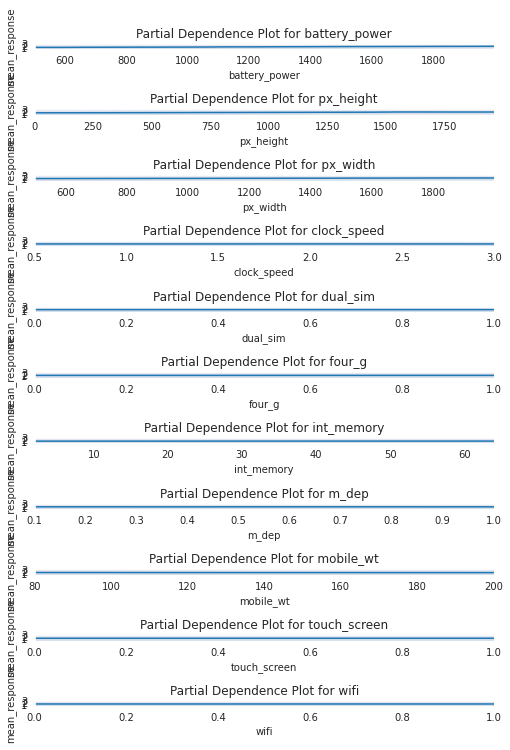

In [139]:
best_model.partial_plot(df, cols=['battery_power', 'px_height', 'px_width', 'clock_speed', 'dual_sim',  'four_g', 'int_memory', 'm_dep', 'mobile_wt', 'touch_screen', 'wifi'])

In [140]:
# h2o.cluster().shutdown()


# Q1. Is the relationship significant?

In [141]:
import statsmodels.api as sm
X = df.drop("price_range")
y = df['price_range']
X = h2o.as_list(X)
y = h2o.as_list(y)
X = sm.add_constant(X)

# Fitting the model
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            price_range   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     1117.
Date:                Mon, 14 Feb 2022   Prob (F-statistic):               0.00
Time:                        04:45:28   Log-Likelihood:                -552.26
No. Observations:                2000   AIC:                             1147.
Df Residuals:                    1979   BIC:                             1264.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.5750      0.062    -25.553

**Here we see that there are multiple factor having p values less than 0.05 like ram, battery etc**

---


# Q3. Is there any multicollinearity in the model?

In [142]:
#Assigning variables to X and y
X = df.drop(['price_range'], axis=1)
X = df[['blue',	'clock_speed', 'ram',	'dual_sim',	'fc',	'four_g', 'int_memory',	'm_dep',	'mobile_wt',	'n_cores',	'pc',	'px_height',	'px_width',	'ram',	'sc_h',	'sc_w',	'talk_time',	'three_g',	'touch_screen',	'wifi']]
y = df['price_range']
X = h2o.as_list(X)
y = h2o.as_list(y)

In [143]:
#fit a OLS model with intercept on PaymentTier,	ExperienceInCurrentDomain,	Age
X = sm.add_constant(X)

# Fit and summary:
model = sm.OLS(y, X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            price_range   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     756.6
Date:                Mon, 14 Feb 2022   Prob (F-statistic):               0.00
Time:                        04:45:28   Log-Likelihood:                -949.57
No. Observations:                2000   AIC:                             1939.
Df Residuals:                    1980   BIC:                             2051.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.9507      0.071    -13.379   

All the parameter are significant therefore it is not colinear

# Q4.  In the multivariate models are predictor variables independent of all the other predictor variables?
# Q5. In in multivariate models rank the most significant predictor variables and exclude insignificant ones from the model.
# Q8. Which independent variables are significant?

In [144]:
# Corelation of the  independent variables
import matplotlib.pyplot as plt
X.iloc[:,1:].corr()

,blue,clock_speed,ram,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram0,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
blue,1.000000,0.021419,0.026351,0.035198,0.003593,0.013443,0.041177,0.004049,-0.008605,0.036161,-0.009952,-0.006872,-0.041533,0.026351,-0.002952,0.000613,0.013934,-0.030236,0.010061,-0.021863
clock_speed,0.021419,1.000000,0.003443,-0.001315,-0.000434,-0.043073,0.006545,-0.014364,0.012350,-0.005724,-0.005245,-0.014523,-0.009476,0.003443,-0.029078,-0.007378,-0.011432,-0.046433,0.019756,-0.024471
ram,0.026351,0.003443,1.000000,0.041072,0.015099,0.007313,0.032813,-0.009434,-0.002581,0.004868,0.028984,-0.020352,0.004105,1.000000,0.015996,0.035576,0.010820,0.015795,-0.030455,0.022669
dual_sim,0.035198,-0.001315,0.041072,1.000000,-0.029123,0.003187,-0.015679,-0.022142,-0.008979,-0.024658,-0.017143,-0.020875,0.014291,0.041072,-0.011949,-0.016666,-0.039404,-0.014008,-0.017117,0.022740
fc,0.003593,-0.000434,0.015099,-0.029123,1.000000,-0.016560,-0.029133,-0.001791,0.023618,-0.013356,0.644595,-0.009990,-0.005176,0.015099,-0.011014,-0.012373,-0.006829,0.001793,-0.014828,0.020085
four_g,0.013443,-0.043073,0.007313,0.003187,-0.016560,1.000000,0.008690,-0.001823,-0.016537,-0.029706,-0.005598,-0.019236,0.007448,0.007313,0.027166,0.037005,-0.046628,0.584246,0.016758,-0.017620
int_memory,0.041177,0.006545,0.032813,-0.015679,-0.029133,0.008690,1.000000,0.006886,-0.034214,-0.028310,-0.033273,0.010441,-0.008335,0.032813,0.037771,0.011731,-0.002790,-0.009366,-0.026999,0.006993
m_dep,0.004049,-0.014364,-0.009434,-0.022142,-0.001791,-0.001823,0.006886,1.000000,0.021756,-0.003504,0.026282,0.025263,0.023566,-0.009434,-0.025348,-0.018388,0.017003,-0.012065,-0.002638,-0.028353
mobile_wt,-0.008605,0.012350,-0.002581,-0.008979,0.023618,-0.016537,-0.034214,0.021756,1.000000,-0.018989,0.018844,0.000939,0.000090,-0.002581,-0.033855,-0.020761,0.006209,0.001551,-0.014368,-0.000409
n_cores,0.036161,-0.005724,0.004868,-0.024658,-0.013356,-0.029706,-0.028310,-0.003504,-0.018989,1.000000,-0.001193,-0.006872,0.024480,0.004868,-0.000315,0.025826,0.013148,-0.014733,0.023774,-0.009964


In [156]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
import statsmodels.api as sm


X = df.drop(['price_range'], axis=1)
X = df[['blue',	'clock_speed', 'ram',	'dual_sim',	'fc',	'four_g', 'int_memory',	'm_dep',	'mobile_wt',	'n_cores',	'pc',	'px_height',	'px_width',	'ram',	'sc_h',	'sc_w',	'talk_time',	'three_g',	'touch_screen',	'wifi']]
y = df['price_range']
X = h2o.as_list(X)
y = h2o.as_list(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20, 
                                                    random_state=32)

# Using Linear Regression with intercept
X_with_constant = sm.add_constant(X_train)
X_with_constant = X_with_constant.to_numpy()
model = sm.OLS(y_train, X_with_constant)
results = model.fit()
results.params
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            price_range   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     602.6
Date:                Mon, 14 Feb 2022   Prob (F-statistic):               0.00
Time:                        04:48:33   Log-Likelihood:                -760.19
No. Observations:                1600   AIC:                             1560.
Df Residuals:                    1580   BIC:                             1668.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9327      0.079    -11.747      0.0

In [157]:
#Determining how good is the model trained with residual
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20, 
                                                    random_state=32)
X_test = sm.add_constant(X_test)
y_pred = results.predict(X_test)
residual = y_test - y_pred

# Q2. Are any model assumptions violated?

In [158]:
#1) Multicolinearity Assumption
vif = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
pd.DataFrame({'vif': vif[0:]}, index=X_train.columns).T

,blue,clock_speed,ram,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram0,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
vif,2.029366,4.250097,inf,2.059318,3.405493,3.182018,3.866062,3.888954,12.620416,4.612527,6.238641,4.282704,11.608283,inf,11.427445,3.779365,4.734322,6.129209,1.963229,2.017804


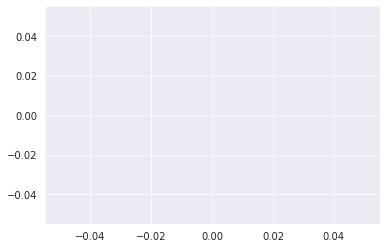

In [159]:
#2) Normality of Residual
import seaborn as sns
sns.set_style("darkgrid")
sns.distplot(residual)

ValueError: ignored

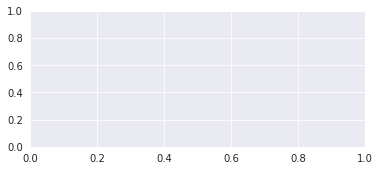

In [154]:
import scipy as sp
fig, ax = plt.subplots(figsize=(6,2.5))
_, (__, ___, r) = sp.stats.probplot(residual, plot=ax, fit=True)

In [155]:
np.mean(residual)

5             NaN
13            NaN
15            NaN
16            NaN
18            NaN
               ..
1986          NaN
1990          NaN
1991          NaN
1999          NaN
price_range   NaN
Length: 401, dtype: float64

In [ ]:
##3) Homoscedasticity
fig, ax = plt.subplots(figsize=(6,2.5))
_ = ax.scatter(y_pred, residual)

In [ ]:
##4) No autocorrelation of residuals
import statsmodels.tsa.api as smt
acf = smt.graphics.plot_acf(residual, lags=40 , alpha=0.05)
acf.show()

# Q6. Does the model make sense?

**Yes the model makes sense, semiconductor are expensive resource for building microchip. The model show strong corelation with the RAM of the mobile phone and the display size which result in increase of the mobile phone prices. Higher the RAM or Display size the price of the phone goes up**

# Q7. Does regularization help?

In [ ]:
#Linear Regression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

lin_regressor=LinearRegression()
mse=cross_val_score(lin_regressor,X,y,scoring='neg_mean_squared_error',cv=5)
mean_mse=np.mean(mse)
print(mean_mse)

In [ ]:
#Ridge Regression
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

ridge=Ridge()
parameters={'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100]}
ridge_regressor=GridSearchCV(ridge,parameters,scoring='neg_mean_squared_error',cv=5)
ridge_regressor.fit(X,y)

In [ ]:
print(ridge_regressor.best_params_)
print(ridge_regressor.best_score_)

In [ ]:
sns.distplot(y_test-prediction_ridge)

# Q9. Which hyperparameters are important?

 

**Trying to run the RandomForestClassifier with hyperparameter to improve the model with n_estimaors**

In [ ]:
classifier= ensemble.RandomForestClassifier(n_jobs=-1)
param_grid = {
    "n_estimators": [100, 200, 300, 400, 500],
    "max_depth": [1,2,3,4,5],
    "criterion": ["gini","entropy"]
    }

from sklearn import model_selection
from sklearn import ensemble
model = model_selection.GridSearchCV(
    estimator= classifier,
    param_grid=param_grid,
    scoring="accuracy",
    verbose=10,
    n_jobs=1,
    cv=5,
)

model.fit(X,y)
print(model.best_score_) 
print(model.best_estimator_.get_params()) 

MIT License

 

Copyright (c) 2022 Pratik Gawand

 

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

 

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

 

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

In [ ]:
## Reference and Citation


In [ ]:
https://stackoverflow.com/
https://www.analyticsvidhya.com/